In [22]:
import numpy as np
import sympy as smp
from scipy import integrate
import matplotlib.pyplot as plt
from torchquad import Simpson, set_up_backend
from scipy.integrate import quad, nquad
import inspect
import pandas as pd

# For interpolation
from scipy.interpolate import RectBivariateSpline, interp2d

import warnings

# Ignorar solo DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*divmax.*")

import logging
# Configuración básica del registro
logging.basicConfig(level=logging.INFO)

In [23]:
# First model
Omega_b0= 0.05
omega_b0= 0.022445
Omega_m0 = 0.32
omega_m0 = 0.143648
h = 0.67
n_s = 0.96
sigma_8 = 0.816
Omega_DE0 = 0.68
w_0 = -1
w_a = 0
gamma = 0.55
Omega_K0 = 1 - (Omega_DE0 + Omega_m0) # FLAT universe!

#[params_cosmo]
#sigma8 = 0.815584
#h = 0.670
#omega_cdm      = 0.2685628338348412
#omega_lambda   = 0.68
#pivot_scalar              = 0.05
#pivot_tensor              = 0.05
#scalar_amp(1)             = 2.12605e-09
#scalar_spectral_index(1)  = 0.96
#Omega_b = 0.05
#Omega_m = 0.32
#Omega_nu = 0.00143717
#n_s = 0.96
#A_s = 2.12605e-09

# Euclid specifications
sigma_epsilon  = 0.3
n_g = 30 #arcmin^-2. Surface density of galaxies
A_survey = 15000 #deg^2
N_z= 10 #number of redshift bins
ng_i = n_g/N_z # Surface density of galaxies per bin/

In [24]:
# Matter power spectrum
P = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/fiducial_eps_0/Pnonlin-zk.txt'
P_deltas = pd.read_csv(P, header=None, delimiter=' ')  # Cambia ' ' por el delimitador correcto

P_array_2d = P_deltas.values
P_list = P_deltas.values.flatten().tolist()
P_array_1d = np.array(P_list) # DONT USE

# Redshift
red = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/fiducial_eps_0/z_values_list.txt'
z = pd.read_csv(red, header=None, delimiter=' ')  # Cambia ' ' por el delimitador correcto

z_list = z.values.flatten().tolist()
z_array = np.array(z_list)

# k values
kas = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/fiducial_eps_0/k_values_list.txt'
k = pd.read_csv(kas, header=None, delimiter=' ')  # Cambia ' ' por el delimitador correcto

k_list = k.values.flatten().tolist()
k_array = np.array(k_list)

In [25]:
Omega_c0 = 0.2685628338348412

Omega_nu0 = 0.00143717

Omega_b0 = 0.05

Omega_m0 = Omega_c0 + Omega_nu0 + Omega_b0

Omega_DE0 = Omega_lambda = (1-Omega_m0)

w0= -1

wa = 0

Omega_K0 = 1 - (Omega_m0 + Omega_DE0)

h = 0.67

c = 299792

sigma8 = 0.816

ns = 0.96

gamma = 6/11

In [26]:
## Derivada con respecto a ns y sigma8

# Matter power spectrum_plus_ns
P_pl_ns_data = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/ns_pl_eps_1p0E-2/Pnonlin-zk.txt'
P_deltas_pl_ns = pd.read_csv(P_pl_ns_data, header=None, delimiter=' ')  

P_pl_ns = P_deltas_pl_ns.values

# Matter power spectrum_minor_ns
P_mn_ns_data = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/ns_mn_eps_1p0E-2/Pnonlin-zk.txt'
P_deltas_mn_ns = pd.read_csv(P_mn_ns_data, header=None, delimiter=' ')  

P_mn_ns = P_deltas_mn_ns.values

# Matter power spectrum_plus_sigma8
P_pl_sig_data = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/s8_pl_eps_1p0E-2/Pnonlin-zk.txt'
P_deltas_pl_sig = pd.read_csv(P_pl_sig_data, header=None, delimiter=' ')  

P_pl_sig = P_deltas_pl_sig.values

# Matter power spectrum_minor_sigma8
P_mn_sig_data = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/s8_mn_eps_1p0E-2/Pnonlin-zk.txt'
P_deltas_mn_sig = pd.read_csv(P_mn_sig_data, header=None, delimiter=' ')  

P_mn_sig = P_deltas_mn_sig.values

In [27]:
# Derivadas numericas

der_P_ns = (P_pl_ns - P_mn_ns)/(2*0.01*ns)

der_P_sigma8 = (P_pl_sig - P_mn_sig)/(2*0.01*sigma8)

In [57]:
class ClassIntegration:
    def __init__(self, params):
        self.z = params['z']

    def E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Oomega_m0 =  (Omega_c0 + Omega_nu0 + Omega_b0) 
        Omega_k0 = 1 - (Oomega_m0 + Omega_DE0) # If it is 0, the error of Omega_m0 increase its difference with respect to the article
        radicando = (Oomega_m0) * (1 + z)**3 + (Omega_DE0 * (1 + z)**(3 * (1 + wa + w0)) * np.exp(-3 * wa * (z / (1 + z)))) + (Omega_k0) * (1 + z)**2
        return np.sqrt(radicando)

    def inverse_E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        return 1 / self.E2(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

    def n_t(self, z):
        z_m, z_0 = 0.9, 0.9 / np.sqrt(2)
        return ((z / z_0)**2) * np.exp(-(z / z_0)**(3 / 2))

    def p_ph(self, z_p, z):
        def gauss(c, z0, s, z, zp):
            return (1 / (np.sqrt(2 * np.pi) * s * (1 + z))) * np.exp(-0.5 * ((z - (c * zp) - z0) / (s * (1 + z)))**2)
        return (1 - 0.1) * gauss(1, 0, 0.05, z, z_p) + 0.1 * gauss(1, 0.1, 0.05, z, z_p)

    def r(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        c = 299792
        H_0 = 100 * h
        z_prime = np.linspace(0, z, 30)
        delta = z / len(z_prime)
        integrand = self.inverse_E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) * delta
        return np.sum(integrand) * (c / H_0)

    def n_i_try(self, i, z):
        z_bins = [0.001, 0.42, 0.56, 0.68, 0.79, 0.9, 1.02, 1.15, 1.32, 1.58, 2.5]
        denominators = np.array([0.04599087, 0.04048852, 0.04096115, 0.03951212, 0.03886145, 0.03944441, 0.03751183, 0.03950185, 0.04042198, 0.03827518])

        def numerator_n_i(i, z):
            z_prime = np.linspace(z_bins[i], z_bins[i + 1], 20)
            delta = (z_bins[i + 1] - z_bins[i]) / len(z_prime)
            multiplication_array = self.n_t(z) * self.p_ph(z_prime, z)
            return np.sum(multiplication_array * delta)

        return numerator_n_i(i, z) / denominators[i]

    def Window2(self, i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        H_0 = 100 * h
        result = []
        for z in self.z:
            z_max = 2.5
            z_prime = np.linspace(z, z_max, 20)
            delta = (z_max - z) / len(z_prime)
            r_true = self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
            n_array = np.array([self.n_i_try(i, zs) for zs in z_prime])
            r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
            integrand = n_array * (1 - ((r_true / c / H_0) / (r_array / c / H_0))) * delta
            result.append(np.sum(integrand))
        return np.array(result)

In [53]:
z_prime = np.linspace(0.001, 2.5, 20)
z_primes = np.linspace(0.001, 2.5, 100)

params = {'z' : z_prime}

CI = ClassIntegration(params)

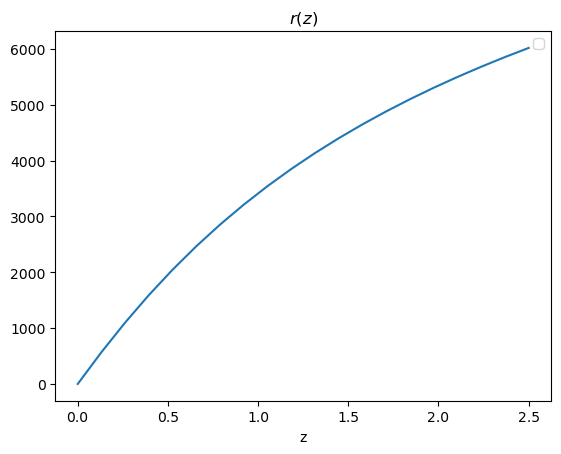

In [65]:
r = np.array([CI.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z in z_prime])
plt.plot(z_prime, r)
plt.xlabel('z')
plt.title('$r(z)$')
plt.legend()

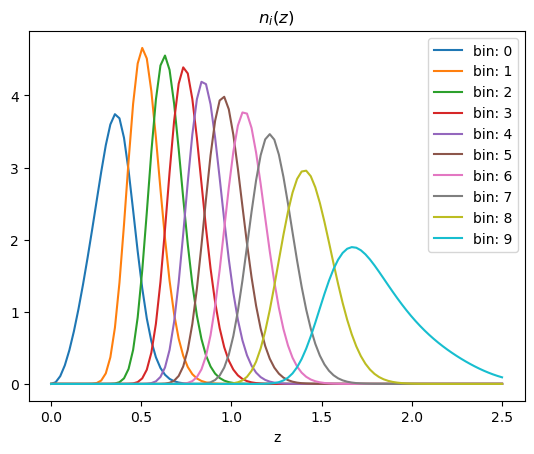

In [61]:
for i in range(10):
    A = np.array([CI.n_i_try(i, zs) for zs in z_primes])
    plt.plot(z_primes, A, label = 'bin: '+str(i))
plt.xlabel('z')
plt.title('$n_i(z)$')
plt.legend()

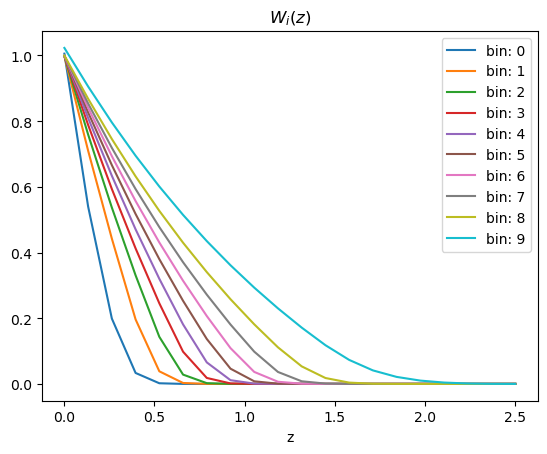

In [62]:
for i in range(10):
    A = CI.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
    plt.plot(z_prime, A,  label = 'bin: '+str(i))
plt.xlabel('z')
plt.title('$W_i(z)$')
plt.legend()

In [67]:
class CosmicShear:
    def __init__(self, cosmic_paramss):
        self.z = cosmic_paramss['z']
        self.l = cosmic_paramss['l']

    def E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Oomega_m0 = (Omega_c0 + Omega_nu0 + Omega_b0) 
        Omega_k0 = 1 - (Oomega_m0 + Omega_DE0)
        radicando = (Oomega_m0) * (1 + z)**3 + Omega_DE0 * (1 + z)**(3 * (1 + wa + w0)) * np.exp(-3 * wa * (z / (1 + z))) + (Omega_k0) * (1 + z)**2
        return np.sqrt(radicando)

    def inverse_E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        return 1 / self.E2(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

    def r(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        c = 299792
        H_0 = 100 * h
        z_prime = np.linspace(0, z, 30)
        delta = z / len(z_prime)
        integrand = self.inverse_E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) * delta
        return np.sum(integrand) * (c / H_0)

    def SN(self, i, j):
        return (0.3**2) / 35454308.58 if i == j else 0

    def D(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        z_prime = np.linspace(0, z, 30)
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Omega_m = (Omega_m0 * (1 + z_prime)**3) / (E_array**2)
        delta = z / len(z_prime)
        integral = np.sum((Omega_m**gamma / (1 + z_prime)) * delta)
        return np.exp(-integral)

    interp_func = RectBivariateSpline(z_array, np.log10(k_array), np.log10(P_array_2d))
    interp_func_ns = RectBivariateSpline(z_array, np.log10(k_array), der_P_ns)
    interp_func_sig = RectBivariateSpline(z_array, np.log10(k_array), der_P_sigma8)

    def PK(self, z, k):
        return 10**(self.interp_func(z, np.log10(k), grid=False))

    def PPS(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5) / self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        P = float(self.PK(z, k))
        return P
    
    def der_PK_ns(self, z, k):
        return self.interp_func_ns(z, np.log10(k), grid=False)

    def der_PPS_ns(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5)/self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        P = float(self.der_PK_ns(z, k))
        return P

    def der_PK_sig(self, z, k):
        return self.interp_func_sig(z, np.log10(k), grid=False)

    def der_PPS_sig(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5)/self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        P = float(self.der_PK_sig(z, k))
        return P
    
    def Cosmic_Shear_l3(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        c = 299792
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        params = {'z': z_prime}
        
        A = ClassIntegration(params)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta)
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_ns(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma): 
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        params = {'z': z_prime}
        
        A = ClassIntegration(params)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.der_PPS_ns(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.der_PPS_ns(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.der_PPS_ns(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta) 
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_sig(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        param = {'z': z_prime}
        
        A = ClassIntegration(param)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.der_PPS_sig(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.der_PPS_sig(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.der_PPS_sig(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta) 
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_Omega(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0*(1+epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0*(1-epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_m0)

    def Der_C_h(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h*(1+epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h*(1-epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*h)

    def Der_C_Omega_b(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0*(1+epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0*(1-epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_b0)

    def Der_C_Omega_DE(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0*(1+epsilon), w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0*(1-epsilon), w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_DE0)

    def Der_C_w0(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0*(1+epsilon), wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0*(1-epsilon), wa, ns, sigma8, gamma)

        A = (C_plus - C_minus)/(epsilon*2*w0)

        return A

    def Der_C_wa(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa + epsilon, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa - epsilon, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2)
    
    def Der_C_gamma(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        '''
        Integra las funciones derivadas
        '''
        
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma*(1+epsilon))
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma*(1-epsilon))

        return (C_plus - C_minus)/(epsilon*2*gamma)

    ##
        
    def Gran_Derivative(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, parametro1):
        if parametro1 == 'Om_m':
            return self.Der_C_Omega(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'Om_b':
            return self.Der_C_Omega_b(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'h':
            return self.Der_C_h(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'Om_DE':
            return self.Der_C_Omega_DE(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'w0':
            return self.Der_C_w0(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'wa':
            return self.Der_C_wa(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'ns':
            return self.Der_C_ns(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'sigma8':
            return self.Der_C_sig(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'gamma':
            return self.Der_C_gamma(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

In [68]:
L_array = np.log10(np.logspace(np.log10(10), np.log10(1500), 100))
cosmic_params = {'l': L_array, 'z': np.linspace(0.001, 2.5, 15)}
B = CosmicShear(cosmic_params)

Text(0.5, 0, 'z')

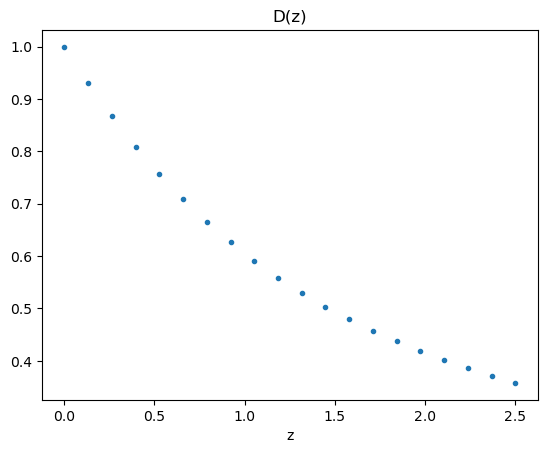

In [91]:
D = [B.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z in z_prime]
plt.plot(z_prime, D, '.')
plt.title('D(z)')
plt.xlabel('z')

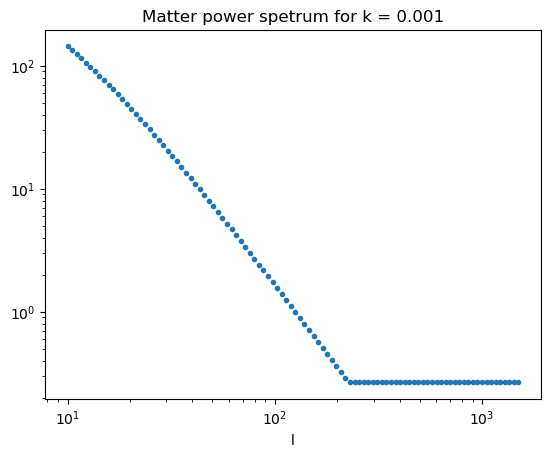

In [99]:
P = [B.PPS(0.001, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for l in L_array]
plt.plot(10**L_array, P, '.')
plt.title('Matter power spetrum for k = 0.001')
plt.xlabel('l')
plt.xscale('log')
plt.yscale('log')

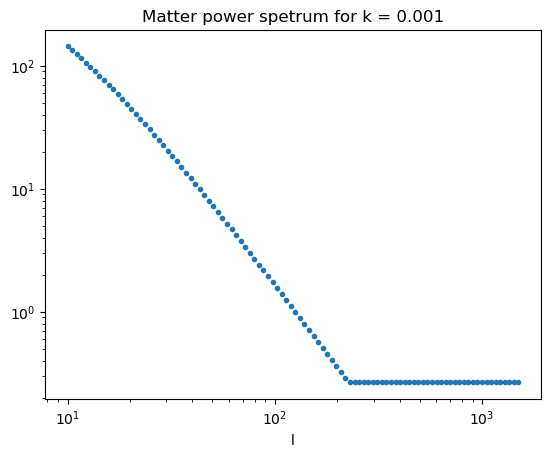

In [102]:
ks = [((10**l + 0.5)/B.r(0.001, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)) for l in L_array]

P = [B.PK(0.001, k) for k in ks]
plt.plot(10**L_array, P, '.')
plt.title('Matter power spetrum for k = 0.001')
plt.xlabel('l')
plt.xscale('log')
plt.yscale('log')

Text(0.5, 0, 'l')

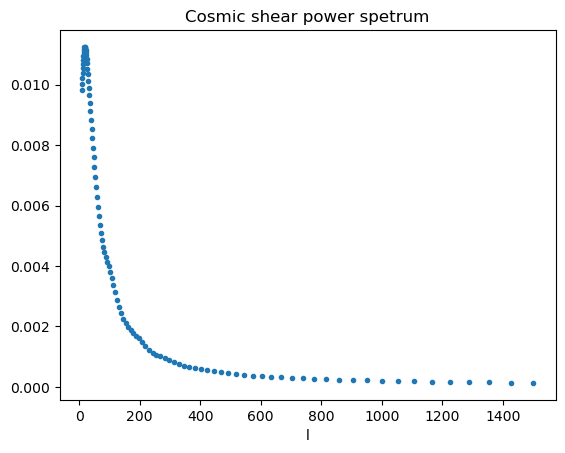

In [74]:
C = B.Cosmic_Shear_l3(0, 0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, C, '.')
plt.title('Cosmic shear power spetrum')
plt.xlabel('l')

Text(0.5, 0, 'l')

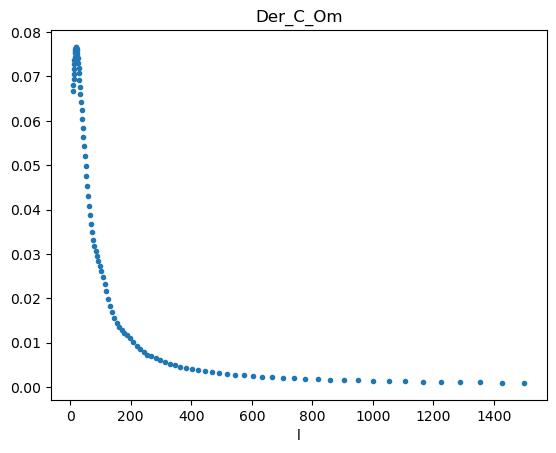

In [77]:
D_om = B.Der_C_Omega(0, 0, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, D_om, '.')
plt.title('Der_C_Om')
plt.xlabel('l')

Text(0.5, 0, 'l')

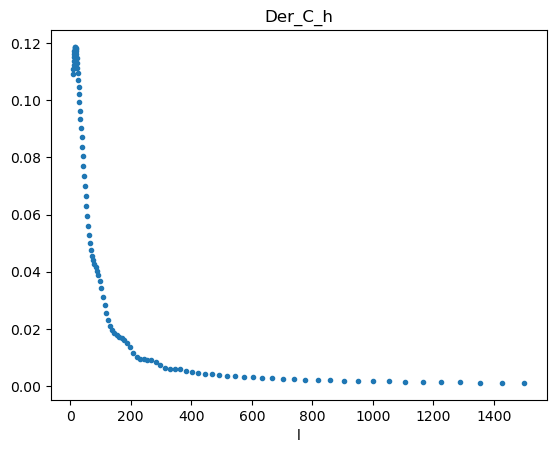

In [78]:
D_h = B.Der_C_h(0, 0, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, D_h, '.')
plt.title('Der_C_h')
plt.xlabel('l')

Text(0.5, 0, 'l')

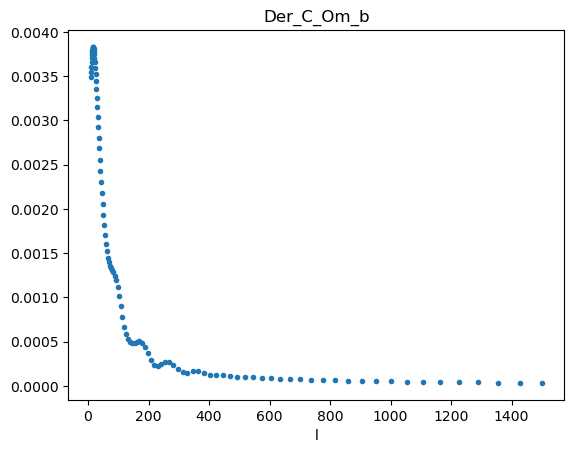

In [79]:
D_om_b = B.Der_C_Omega_b(0, 0, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, D_om_b, '.')
plt.title('Der_C_Om_b')
plt.xlabel('l')

Text(0.5, 0, 'l')

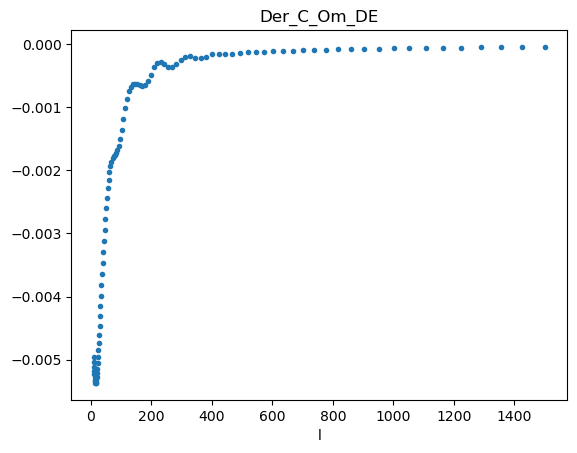

In [80]:
D_om_DE = B.Der_C_Omega_DE(0, 0, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, D_om_DE, '.')
plt.title('Der_C_Om_DE')
plt.xlabel('l')

Text(0.5, 0, 'l')

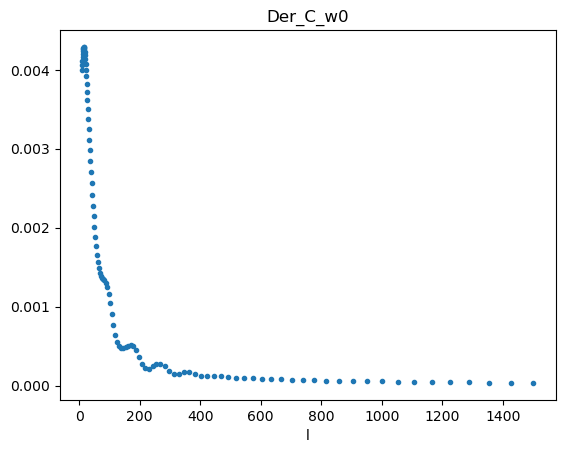

In [81]:
D_om_w0 = B.Der_C_w0(0, 0, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, D_om_w0, '.')
plt.title('Der_C_w0')
plt.xlabel('l')

Text(0.5, 0, 'l')

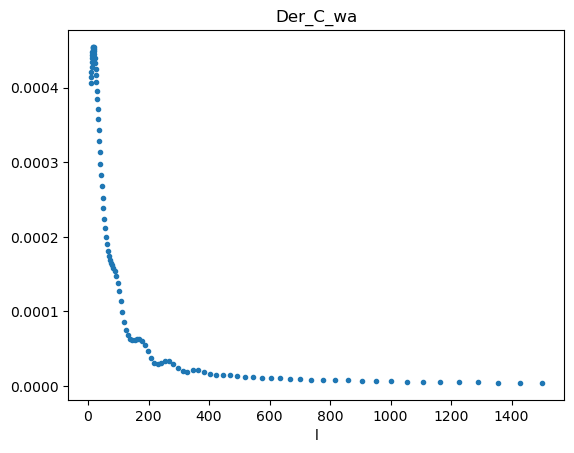

In [82]:
D_om_wa = B.Der_C_wa(0, 0, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, D_om_wa, '.')
plt.title('Der_C_wa')
plt.xlabel('l')

Text(0.5, 0, 'l')

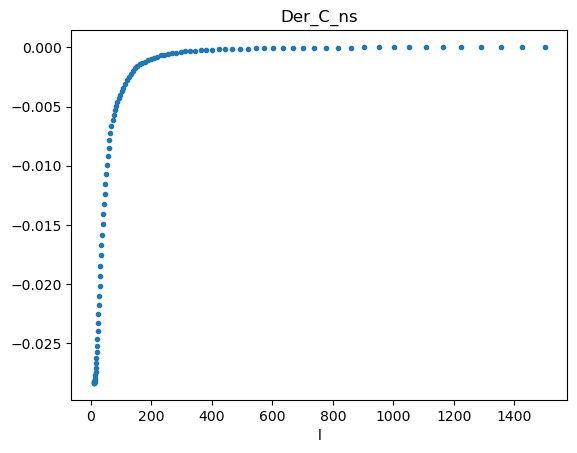

In [84]:
D_om_ns = B.Der_C_ns(0, 0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, D_om_ns, '.')
plt.title('Der_C_ns')
plt.xlabel('l')

Text(0.5, 0, 'l')

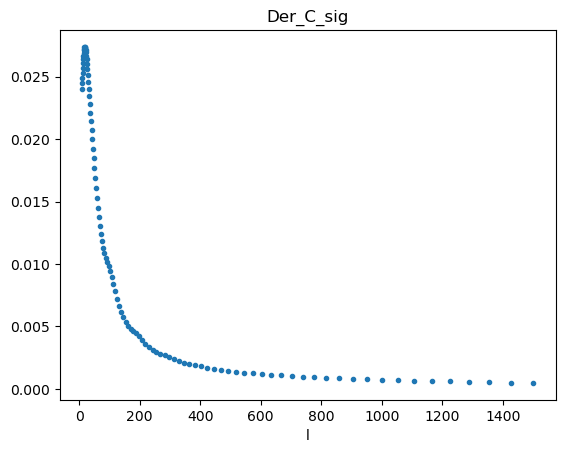

In [87]:
D_om_sig = B.Der_C_sig(0, 0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, D_om_sig, '.')
plt.title('Der_C_sig')
plt.xlabel('l')

Text(0.5, 0, 'l')

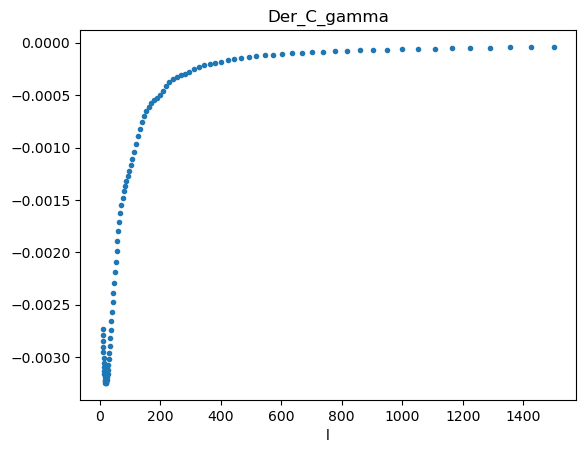

In [89]:
D_om_gamm = B.Der_C_gamma(0, 0, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

plt.plot(10**L_array, D_om_gamm, '.')
plt.title('Der_C_gamma')
plt.xlabel('l')